# Multi-label classification model

The model aims to classify the transcripts' sentences that belong to three different international courts.

The dataset that is considered for this project can be found at: TBD

The procedure followed to extract such sentences is described as follows:
- Relevant cases were chosen directly from the webpage of each international court
- Each transcript has a different format file (*.pdf, *.doc, or *.htm{( )|l}) and a cleaning process was applied in order to remove either uninformative or irrelevant information for the classification model
- Each cleaned transcript version was stored into a .txt file
- a
- b
- etc. 

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

GLB_INSTALL_DEPENDENCIES = True
GLB_USE_DRIVE_ACCOUNT = True

In [2]:
if GLB_INSTALL_DEPENDENCIES:
    !pip install transformers
    !pip install torch
    !pip install openpyxl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 72.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 81.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 24.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
if GLB_USE_DRIVE_ACCOUNT:
  from google.colab import drive
  drive.mount('/content/drive')
  %cd /content/drive/MyDrive/"Colab Notebooks"
  username = "IsaacOlguin"
  repository =  "AutomatedTraumaDetectionInGCT"
  %cd {repository}
  %pwd

In [4]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import json

import src.multi_label_classif_model_utilities as mlclassif_utilities

## Globals

In [5]:
PATH_DATASET = "input/dataset/Dataset.xlsx"
PATH_DIR_LOGS = "logs/"
PATH_DIR_MODELS = "models/"
INDEX_COLUMNS_DATASET = 0
LIST_NAME_COLUMNS_DATASET = ["id_document", "id_annotation", "span", "role", "trauma", "court"]

GLB_RETURN_ATTENTION_MASK = True
GLB_CROSS_VALIDATION = True
GLB_SAVE_MODEL = False
GLB_STORE_STATISTICS_MODEL = False
GLB_TEST_MODEL = False

# Globals for the model
EPOCHS = 3
EMBEDDING_SIZE = 512
NUM_CLASSES = 7
BATCH_SIZE = 8

## Dataset

In [6]:
df_dataset = mlclassif_utilities.import_dataset_from_excel(PATH_DATASET, INDEX_COLUMNS_DATASET, LIST_NAME_COLUMNS_DATASET)
df_dataset.head()

,id_document,id_annotation,span,role,trauma,court
0,63a16b2597ad59b4cfc56c2d,63a16c4997ad59b4cfc56c2f,THE INTERNATIONAL CRIMINAL TRIBUNAL \t\tCASE N...,Court Proceedings,0,ICTY
1,63a16b2597ad59b4cfc56c2d,63a16c4e97ad59b4cfc56c30,"THE PRESIDING JUDGE: Miss Hollis, could you c...",JudgeProc,0,ICTY
2,63a16b2597ad59b4cfc56c2d,63a16c5297ad59b4cfc56c31,"MISS HOLLIS: Yes, your Honour.",LawyerProc,0,ICTY
3,63a16b2597ad59b4cfc56c2d,63a16c5697ad59b4cfc56c32,"Examined by MISS HOLLIS, continued.",Court Proceedings,0,ICTY
4,63a16b2597ad59b4cfc56c2d,63a16c5c97ad59b4cfc56c33,"THE PRESIDING JUDGE: You may be seated, Mrs. ...",JudgeQA,0,ICTY


In [7]:
classes_dataset = mlclassif_utilities.get_unique_values_from_dataset(df_dataset, "role")
print(f"Num of different roles in the dataset is {len(classes_dataset)} which are:")
for index, elem in enumerate(classes_dataset):
    print("\t", index+1, "-", elem)
    
courts_dataset = mlclassif_utilities.get_unique_values_from_dataset(df_dataset, "court")
print(f"Num of different courts in the dataset is {len(courts_dataset)} which are:")
for index, elem in enumerate(courts_dataset):
    print("\t", index+1, "-", elem)

Num of different roles in the dataset is 7 which are:
	 1 - Court Proceedings
	 2 - JudgeProc
	 3 - LawyerProc
	 4 - JudgeQA
	 5 - LawyerQA
	 6 - Witness
	 7 - Accused
Num of different courts in the dataset is 3 which are:
	 1 - ICTY
	 2 - ECCC
	 3 - ICTR


### Distribution of all classes within the dataset

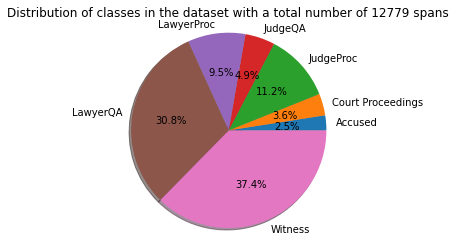

,role,span
0,Accused,316
1,Court Proceedings,461
2,JudgeProc,1437
3,JudgeQA,630
4,LawyerProc,1220
5,LawyerQA,3942
6,Witness,4773


In [8]:
distribution_classes = mlclassif_utilities.get_distribution_classes_from_dataset(df_dataset, ["role"], "span")

labels = list(distribution_classes["role"])
sizes = list(distribution_classes["span"])

fig1, ax1 = plt.subplots()
ax1.set_title(f'Distribution of classes in the dataset with a total number of {distribution_classes["span"].sum()} spans')
ax1.pie(sizes, labels=labels, autopct='%2.1f%%', shadow=True, startangle=0) #'%1.1f%%'
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

distribution_classes

## Setup

### Device

Get the GPU device if exists, otherwise get the cpu as default dev.

In [9]:
device = mlclassif_utilities.get_gpu_device_if_exists()

print(f"\n\n==> Selected device is '{device}' <==")

There are 1 GPU(s) available.

These are the available devices:
	 1 - Tesla T4


==> Selected device is 'cuda' <==


## Model

### Tokenizer

In [10]:
#If no parameters are sent, default values are considered. 
#    IDModel:      Bert
#    Model namel:  bert-base-uncased
#    Do uncase:    True

tokenizer = mlclassif_utilities.get_tokenizer() 

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Bert tokenizer was loaded successfully (bert-base-uncased) 
	 do_lower_case=True


### Get list of all sentences and all classes

In [11]:
list_all_spans = list(df_dataset["span"])
list_all_classes = list(df_dataset["role"])

### Max length of a sentence among all sentences within the dataset

In [12]:
mlclassif_utilities.get_max_length_of_a_sentence_among_all_sentences(tokenizer, list_all_spans, False)

Max sentence length:  342 found at index 12262 . Sentence is:


 Q. I'm going to quote what you said. Well, in fact, you mentioned his name at -- in the written record, D40/23, in Khmer 00165357; in French 00490912; English 00223212. Question: "Among the prisoners who were brought to the centre, were some released?" Your answer: "Only the female prisoners with their children were released, in particular, the family of Yeay Nhor," N-H-O-R, "And most of the prisoners died because they were ill or because they were executed. Very few prisoners survived. That is to say, Sen, who was one of them, who lives next to Angkor Leay pagoda." End of quote. And here you spoke about Yeay Nha's family, at answers 90 to 92, at E319.1.3. So those are answers 90 to 92, you spoke about certain members of Yeay Nhor's family, or Yeay Nha, who were detained but who survived Krang Ta Chan. And you also said in your written record of interview, which I just quoted from, that prisoners died because they had bee

342

### Tokenize sentences

In [13]:
# If _return_attention_mask, a tuple of two lists is given (tensor_of_inputs, tensor_of_attention_masks)
all_spans_tokenized = mlclassif_utilities.get_all_spans_tokenized(
    mlclassif_utilities.GLB_BERT_MODEL_ID, 
    tokenizer,
    list_all_spans,
    _add_special_tokens = True, 
    _max_length = 512,
    _pad_to_max_length = True,
    _return_attention_mask = GLB_RETURN_ATTENTION_MASK, 
    type_tensors = mlclassif_utilities.GLB_PYTORCH_TENSOR_TYPE
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [14]:
input_ids = None
attention_masks = None

if GLB_RETURN_ATTENTION_MASK:
    input_ids = mlclassif_utilities.convert_list_into_pytorch_tensor(all_spans_tokenized[0])
    attention_masks = mlclassif_utilities.convert_list_into_pytorch_tensor(all_spans_tokenized[1])
else:
    input_ids = mlclassif_utilities.convert_list_into_pytorch_tensor(all_spans_tokenized)

### Split dataset

In [15]:
numeric_classes = mlclassif_utilities.convert_list_span_classes_into_numeric_values(classes_dataset, list_all_classes)
numeric_classes = mlclassif_utilities.convert_list_labels_into_pytorch_tensor(numeric_classes)

In [16]:
### Split dataset
if not GLB_CROSS_VALIDATION:
    train_labels_corpus, train_input_ids, train_attention_masks, val_labels_corpus, val_input_ids, val_attention_masks, test_labels_corpus, test_input_ids, test_attention_masks = mlclassif_utilities.split_dataset_train_val_test(numeric_classes, input_ids, attention_masks)
else:
    ### Pending k-Fold
    train_val_corpus_cross_validation, test_corpus_cross_validation = mlclassif_utilities.split_dataset_train_val_test_k_fold(numeric_classes, input_ids, attention_masks, 0.1)

    #test_labels_corpus, test_input_ids, test_attention_masks = 
    #train_labels_corpus, train_input_ids, train_attention_masks, val_labels_corpus, val_input_ids, val_attention_masks,

0) Len of train_index=9200 VS len of val_index=2301
1) Len of train_index=9201 VS len of val_index=2300
2) Len of train_index=9201 VS len of val_index=2300
3) Len of train_index=9201 VS len of val_index=2300
4) Len of train_index=9201 VS len of val_index=2300


### Create datasets and dataloaders

In [ ]:
"""
train_dataset = mlclassif_utilities.create_tensor_dataset(train_input_ids, train_attention_masks, train_labels_corpus)
val_dataset = mlclassif_utilities.create_tensor_dataset(val_input_ids, val_attention_masks, val_labels_corpus)
test_dataset = mlclassif_utilities.create_tensor_dataset(test_input_ids, test_attention_masks, test_labels_corpus)

train_dataloader = mlclassif_utilities.create_dataloader(train_dataset, BATCH_SIZE)
val_dataloader = mlclassif_utilities.create_dataloader(val_dataset, BATCH_SIZE)
test_dataloader = mlclassif_utilities.create_dataloader(test_dataset, BATCH_SIZE)
"""

### Create model

In [ ]:
model = mlclassif_utilities.create_model(
    mlclassif_utilities.GLB_BERT_MODEL_ID,
    mlclassif_utilities.GLB_BERT_BASE_UNCASED_MODEL_NAME,
    NUM_CLASSES,
    True #RunInGPU
)

### Get optimizer and scheduler

In [18]:
optimizer = mlclassif_utilities.get_optimizer(model)
scheduler = mlclassif_utilities.get_scheduler(optimizer)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Train and validate the model

In [ ]:
if not GLB_CROSS_VALIDATION:
  train_dataset = mlclassif_utilities.create_tensor_dataset(train_input_ids, train_attention_masks, train_labels_corpus)
  val_dataset = mlclassif_utilities.create_tensor_dataset(val_input_ids, val_attention_masks, val_labels_corpus)
  test_dataset = mlclassif_utilities.create_tensor_dataset(test_input_ids, test_attention_masks, test_labels_corpus)

  train_dataloader = mlclassif_utilities.create_dataloader(train_dataset, BATCH_SIZE)
  val_dataloader = mlclassif_utilities.create_dataloader(val_dataset, BATCH_SIZE)
  test_dataloader = mlclassif_utilities.create_dataloader(test_dataset, BATCH_SIZE)

  model, statistics_model = mlclassif_utilities.train_and_validate(model, device, EPOCHS, optimizer, scheduler, train_dataloader, val_dataloader, numeric_classes.tolist())

else:
  for index_cross_val in range(len(train_val_corpus_cross_validation)):
    train_dataset = mlclassif_utilities.create_tensor_dataset(train_val_corpus_cross_validation[index_cross_val][1], train_val_corpus_cross_validation[index_cross_val][2], train_val_corpus_cross_validation[index_cross_val][0])
    val_dataset = mlclassif_utilities.create_tensor_dataset(train_val_corpus_cross_validation[index_cross_val][4], train_val_corpus_cross_validation[index_cross_val][5], train_val_corpus_cross_validation[index_cross_val][3])

    train_dataloader = mlclassif_utilities.create_dataloader(train_dataset, BATCH_SIZE)
    val_dataloader = mlclassif_utilities.create_dataloader(val_dataset, BATCH_SIZE)

    print('=')
    print(f"Cross-Validation Split {(index_cross_val+1)}/{len(train_val_corpus_cross_validation)}")
    print('=')
    model, statistics_model = mlclassif_utilities.train_and_validate(model, device, EPOCHS, optimizer, scheduler, train_dataloader, val_dataloader, numeric_classes.tolist())

### Store JSON statistics model

In [ ]:
if GLB_STORE_STATISTICS_MODEL:
    mlclassif_utilities.save_json_file_statistics_model(statistics_model, PATH_DIR_LOGS)

### Test model

In [ ]:
if GLB_TEST_MODEL:
    mlclassif_utilities.test_model(model, device, test_dataloader, numeric_classes.tolist())

### Save model

In [ ]:
if GLB_SAVE_MODEL:
    mlclassif_utilities.save_model(model, "model_bert_5_classes", PATH_DIR_MODELS)